<a href="https://colab.research.google.com/github/BJHeemskerk/DeepLearning_2024/blob/jesse/Portfolio_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Voorspellen van huisprijzen**

|Teamleden|Kaggle Username|GitHub Username|
|--|--|--|
|Nima Ghafar|NimaGhafar|NimaGhafar|
|Busse Heemskerk|bussejheemskerk|BJHeemskerk|
|Henry Lau|||
|Jesse van Leeuwen|22096337|22096337|

-- Opdrachtomschrijving --

## Inhoudsopgave
1. [H1: Importeren en inladen](#h1)
2. [H2: EDA](#h2)
3. [H3: Fully Connected Neural Network](#h3)

## H1: Importeren en inladen <a name='h1'></a>
Eerst zullen de verschillende gebruikte libaries worden geimporteerd.

In [ ]:
# Importeren van veel gebruikte libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import datetime

# Importeren libaries voor aanpassen/behandelen features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Importeren DL libaries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Nu zal de data worden ingeladen. Om hiermee te beginnen zullen de csv bestanden worden ingeladen.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/DeepLearning_2024/Opdracht 1')


In [ ]:
# Inladen van csv bestanden
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Tonen van de data
display(train_data.head(), test_data.head())

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
0,501,3,2.0,2330,35.6406,-120.7003
1,502,3,2.5,1339,35.6406,-120.7003
2,503,3,2.0,1472,35.6406,-120.7003
3,504,4,4.0,2681,35.6406,-120.7003
4,505,3,2.5,1935,33.8085,-117.9228


In de volgende code cel wordt de data van elke afbeelding in de train en de test map opgehaald.

In [ ]:
# Aanmaken van te vullen lijsten
file_paths_tr = []
imgdata_tr = []
file_paths_te = []
imgdata_te = []

# Opzetten directories
directories = ["Train", "Test"]

# Ophalen van de bestanden
# Loopen over directories
for directory in directories:
    directory_path = os.path.join('/content/drive/My Drive/Colab Notebooks/DeepLearning_2024/Opdracht 1', directory)
    # Loopen over alle bestanden
    for file in os.listdir(directory_path):
        # Alleen checken van .jpg bestanden
        if file.endswith(".jpg"):
            # Aanmaken van pad naar het bestand.
            file_path = os.path.join(directory_path, file)

            # Openen van de afbeelding en omzetten naar np.array
            img = Image.open(file_path)
            img_array = np.array(img)

            # Vullen van juiste lijsten op basis van ID
            if int(file.split('.')[0]) > 500:  # We halen de ID uit de bestandsnaam
                file_paths_te.append(file_path)
                imgdata_te.append(img_array)
            else:
                file_paths_tr.append(file_path)
                imgdata_tr.append(img_array)


Nu alle data in lijsten is gezet kunnen er dataframes worden aangemaakt met de data van de afbeeldingen. Door de grootte van de arrays kan dit even duren.

In [ ]:
# Initieren van het dataframe
train_images = pd.DataFrame(columns=["House ID", "FilePath", "ImgData"])
test_images = pd.DataFrame(columns=["House ID", "FilePath", "ImgData"])

# Aanvullen train dataset
train_images["House ID"] = train_data["House ID"]
train_images["FilePath"] = file_paths_tr
train_images["ImgData"] = imgdata_tr

# Aanvullen test dataset
test_images["House ID"] = test_data["House ID"]
test_images["FilePath"] = file_paths_te
test_images["ImgData"] = imgdata_te

# Tonen van de dataframes
display(train_images.head(), test_images.head())

,House ID,FilePath,ImgData
0,1,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[166, 122, 73], [172, 128, 79], [168, 124, 7..."
1,2,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[234, 234, 234], [233, 233, 233], [231, 231,..."
2,3,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[156, 126, 100], [164, 137, 110], [181, 154,..."
3,4,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[187, 149, 64], [187, 149, 64], [186, 148, 6..."
4,5,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[185, 157, 94], [184, 156, 93], [183, 155, 9..."


,House ID,FilePath,ImgData
0,501,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[250, 250, 250], [251, 251, 251], [245, 245,..."
1,502,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[196, 186, 177], [194, 184, 175], [205, 195,..."
2,503,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[222, 205, 185], [229, 212, 192], [221, 204,..."
3,504,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[255, 253, 214], [255, 253, 214], [254, 252,..."
4,505,/content/drive/My Drive/Colab Notebooks/DeepLe...,"[[[22, 20, 21], [36, 34, 35], [36, 34, 35], [3..."


Vervolgens zullen de dataframes worden getest door de afbeeldingen te tonen.

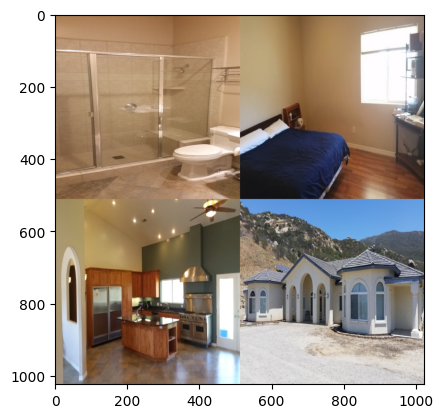

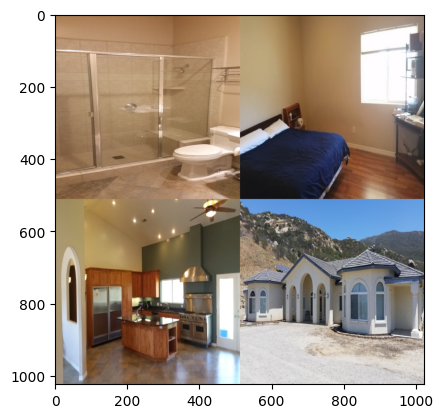

In [ ]:
# Ophalen van pad naar afbeelding
image_path = train_images["FilePath"][0]

# Openen afbeelding
img = Image.open(image_path)

# Omzetten afbeelding naar np.array
img_array = np.array(img)

# Tonen van de afbeelding
plt.imshow(img)
plt.show()

# Opnieuw tonen van de afbeelding via DF
plt.imshow(train_images["ImgData"][0])
plt.show()

## H2: EDA <a name='h2'></a>

- [ ] Voer een Exploratieve Data Analyse (EDA) uit:
    - [ ] Lees de afbeeldingen in en toon enkele afbeeldingen.
    - [ ] Laad het metadatabestand en maak relevante visualisaties om de relaties tussen de targetvariabele en de andere variabelen te onderzoeken.
- [ ] Beschrijf wat de belangrijkste bevindingen zijn van de EDA.

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
0,501,3,2.0,2330,35.6406,-120.7003
1,502,3,2.5,1339,35.6406,-120.7003
2,503,3,2.0,1472,35.6406,-120.7003
3,504,4,4.0,2681,35.6406,-120.7003
4,505,3,2.5,1935,33.8085,-117.9228


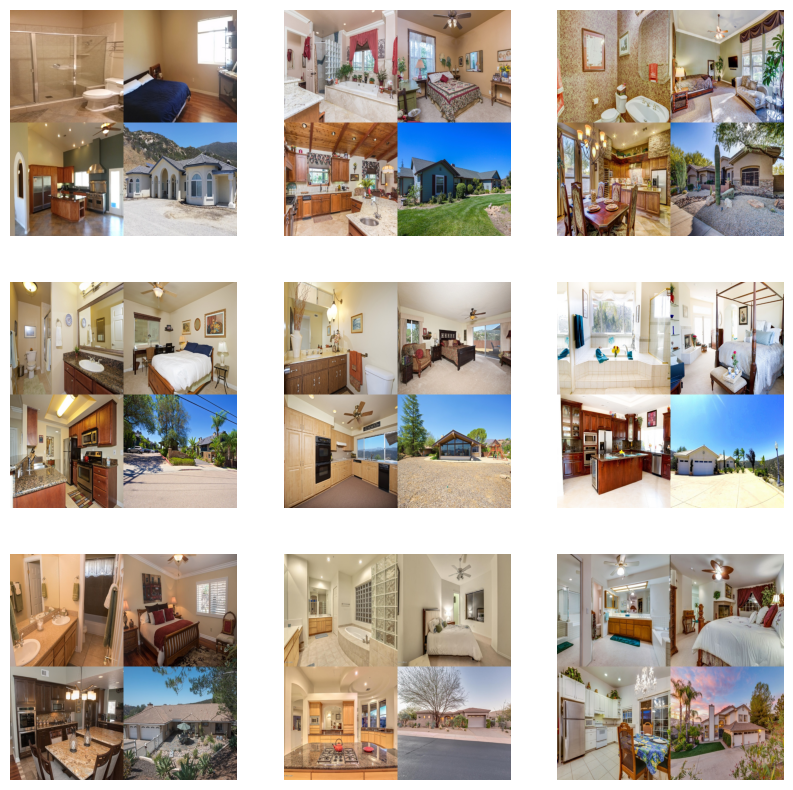

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns

# Load the metadata
train_df = pd.read_csv(r'train.csv')
test_df = pd.read_csv(r'test.csv')

# Display the first few rows of the dataframe
display(train_df.head())
display(test_df.head())

# Read and display images
train_images_dir = r'Train'
test_images_dir = r'Test'

# Display some images from the train set
train_images = os.listdir(train_images_dir)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = cv2.imread(os.path.join(train_images_dir, train_images[i]))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

# Display some images from the test set
if 'Price' not in train_df.columns:
    raise KeyError("Column 'target' does not exist in the dataframe.")


Train dataframe shape: (500, 7)
Train dataframe summary statistics:


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,250.500000,3.350000,2.669500,2369.64600,35.128844,-116.469049,5.980218e+05
std,144.481833,1.172283,1.017578,1208.18261,2.386173,6.554434,5.240649e+05
min,1.000000,1.000000,1.000000,701.00000,32.631500,-122.368300,2.200000e+04
25%,125.750000,2.000000,2.000000,1440.00000,33.808200,-119.802500,2.350000e+05
50%,250.500000,3.000000,2.500000,2097.50000,33.920800,-117.609600,5.300000e+05
75%,375.250000,4.000000,3.000000,3104.50000,35.640600,-116.371300,7.490000e+05
max,500.000000,10.000000,7.000000,9583.00000,47.791800,-87.885900,5.858000e+06


Train dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB


None

Test dataframe shape: (35, 6)
Test dataframe summary statistics:


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,518.000000,3.771429,2.600000,2297.171429,36.631043,-120.662114
std,10.246951,0.910259,0.591608,1457.127886,1.837672,1.670038
min,501.000000,2.000000,1.500000,987.000000,33.808500,-121.775800
25%,509.500000,3.000000,2.000000,1580.000000,34.724550,-121.775800
50%,518.000000,4.000000,2.500000,2012.000000,37.965800,-121.775800
75%,526.500000,4.000000,3.000000,2387.500000,37.965800,-119.311550
max,535.000000,7.000000,4.000000,9536.000000,37.965800,-117.922800


Test dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   35 non-null     int64  
 1   Bedrooms   35 non-null     int64  
 2   Bathrooms  35 non-null     float64
 3   Area       35 non-null     int64  
 4   Latitude   35 non-null     float64
 5   Longitude  35 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 1.8 KB


None

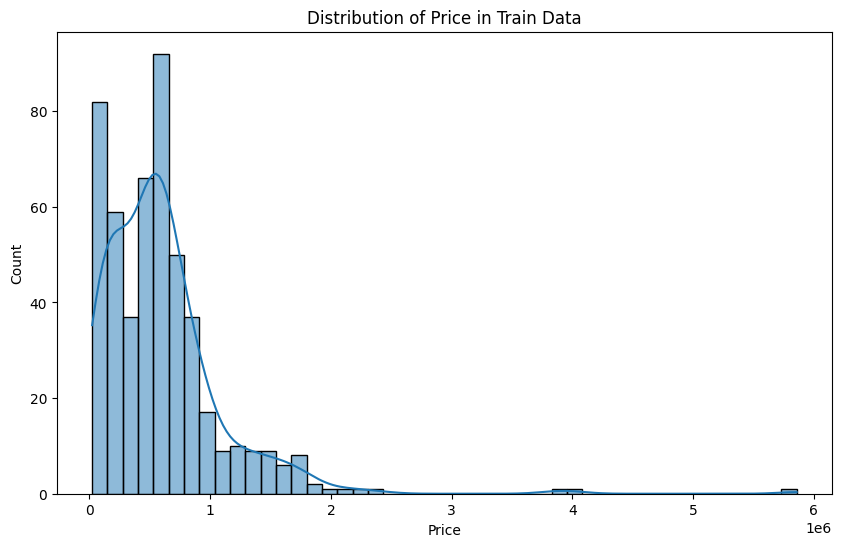

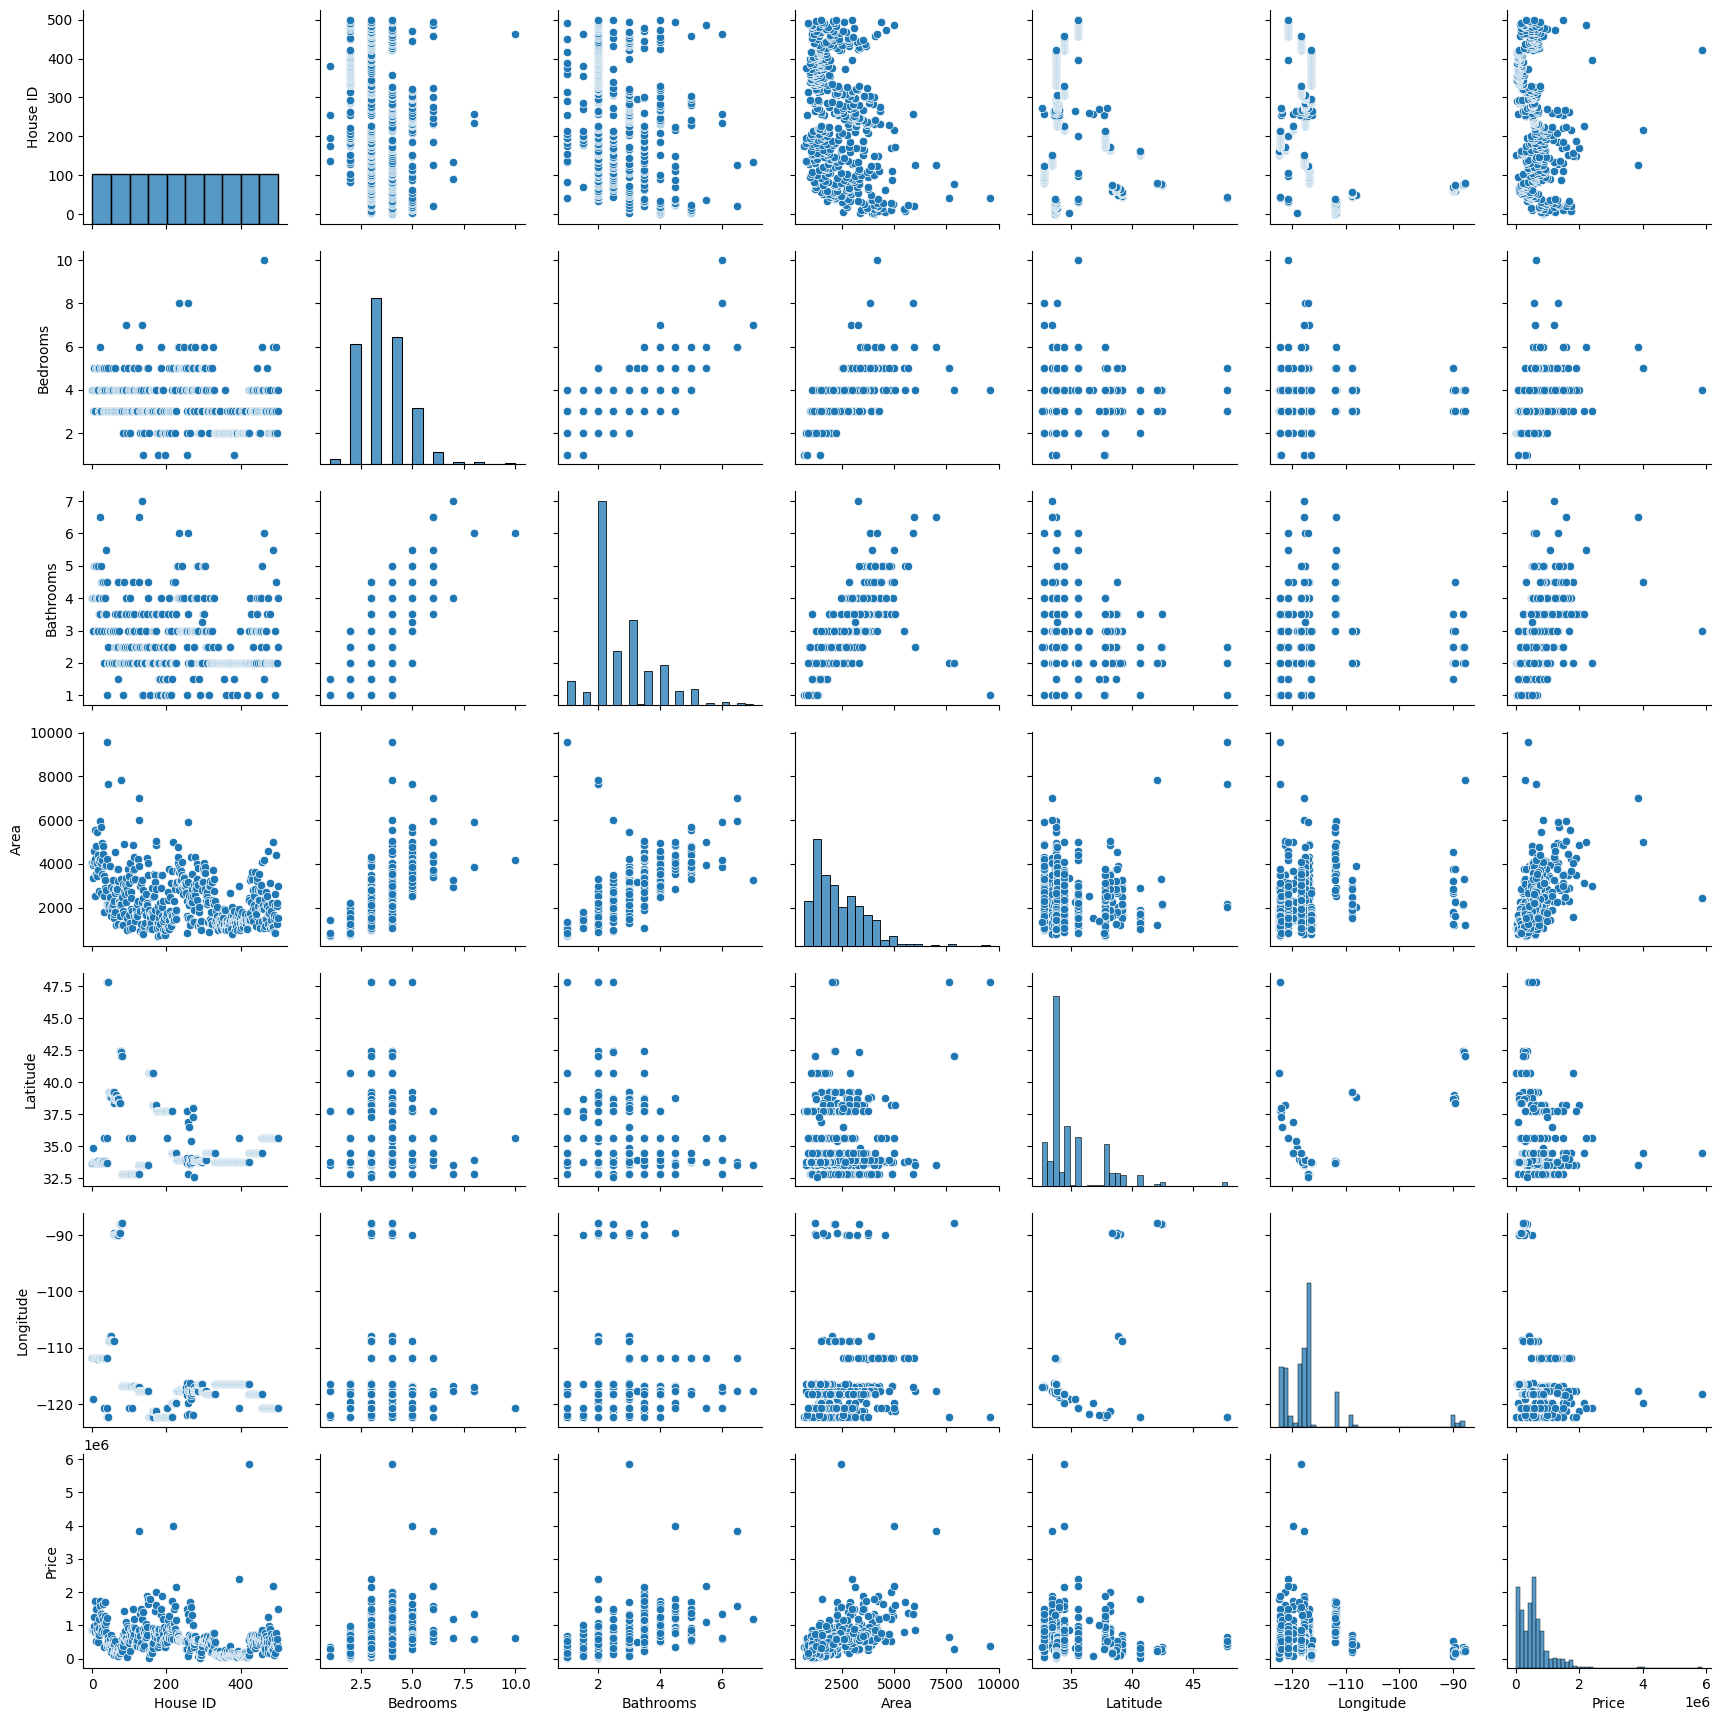

In [ ]:
# EDA on train dataframe
print("Train dataframe shape:", train_df.shape)

# Use describe() for summary statistics
print("Train dataframe summary statistics:")
display(train_df.describe(include='all'))

# Use info() for data types and missing values
print("Train dataframe info:")
display(train_df.info())

# EDA on test dataframe
print("Test dataframe shape:", test_df.shape)

# Use describe() for summary statistics
print("Test dataframe summary statistics:")
display(test_df.describe(include='all'))

# Use info() for data types and missing values
print("Test dataframe info:")
display(test_df.info())

# Visualize the distribution of the target variable in the train dataframe
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Price'], kde=True)
plt.title('Distribution of Price in Train Data')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

sns.pairplot(train_df)
plt.show()



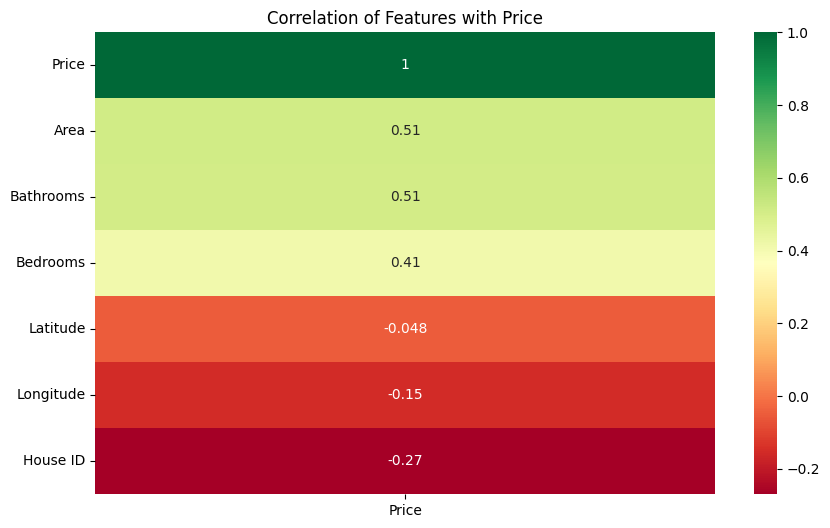

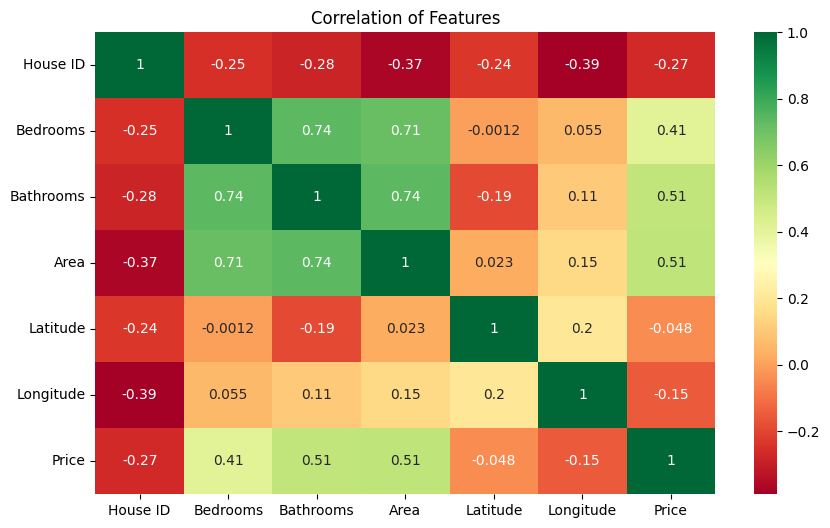

In [ ]:
# Maak een heatmap met  cmap='RdYlGn' alleen op "Price" in de train dataframe en in volgorde van hoog naar laag
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.corr()[['Price']].sort_values(by='Price', ascending=False), annot=True, cmap='RdYlGn')
plt.title('Correlation of Features with Price')
plt.show()

# Maak een heatmap met  cmap='RdYlGn' voor alle kolommen in de train dataframe en in volgorde van hoog naar laag

plt.figure(figsize=(10, 6))
sns.heatmap(train_df.corr(), annot=True, cmap='RdYlGn')
plt.title('Correlation of Features')
plt.show()


## H3: Splitsen en scalen

Voordat er neurale netwerken kunnen worden opgesteld, zal eerst nog de train_data dataset worden opgesplitst in een test en een validatie set.

In [ ]:
# Aanmaken van de random_state SEED
SEED = 42

# Opslitsten van data in X en y
X = train_data.drop(['House ID', 'Price'], axis=1)
y = train_data['Price']

# Toepassen van train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.1, random_state=SEED
                                       )

Vervolgens moet de data worden gescaled, dit zorgt ervoor dat het model betere verbanden kan leggen tussen de verschillende variabelen.

In [ ]:
# Scalen van de gesplitste data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Scalen van de test_data
# Aanmaken lijst met nodige kolomnamen
kolomnamen = ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude"]

# Scalen van de nodige kolommen
test_fe = test_data[kolomnamen]
sc_test_fe = scaler.fit_transform(test_fe)

**versie 1 van het model (fcnn-1)**

## H3: Fully Connencted Neural Network <a name='h3'></a>

Nu kan er worden begonnen met het opzetten van verschillende voorspellingen. Het eerste type voorspelling dat voor zal komen is een Fully Connected Neural Network. Dit netwerk bestaat uit de volgende lagen:

**Input laag:**<br>
De input laag van een neuraal netwerk bestaat uit een bepaald aantal neuronen. Het aantal neuronen moet gelijk zijn aan het aantal features dat in de dataset beschikbaar is. In onze datasets zijn er 5 features te vinden, dus heeft de input laag 5 neuronen.

In alle hidden layers is gebruik gemaakt van een trial & error aanpak, waarmee er met verschillende hoeveelheden van neuronen en verschillende activatie functies is getest. Uiteindelijk kwamen hier de volgende aantallen en activaties uit:

**Hidden Layer 1:**<br>
- Neuronen: 128
- Activatie: Rectified Linear Unit

**Hidden Layer 2:**<br>
- Neuronen: 64
- Activatie: Rectified Linear Unit

**Hidden Layer 3:**<br>
- Neuronen: 64
- Activatie: Rectified Linear Unit

**Hidden Layer 4:**<br>
- Neuronen: 16
- Activatie: Rectified Linear Unit

Voor de output laag geldt ongeveer hetzelfde als voor de input laag. Het aantal neuronen in de output laag hoort gelijk te zijn aan het aantal klassen die worden voorspeld bij classificatie. Bij regressie taken is er vaak maar 1 neuron in de output laag aanwezig, omdat er een eenvoudige numerieke voorspelling wordt gemaakt. In ons regressie probleem is deze waarde de huisprijs. Bij regressie is er ook sprake van de activatie functie 'linear', ookwel bekend als geen activatie.

Nu de data is gesplitst zal er een Fully Connected Neural Network worden opgebouwd.

In [ ]:
# Aanmaken NN mbv Sequential API
fcnn = Sequential()

# Toevoegen input en eerste hidden layer
fcnn.add(Dense(128, input_shape=(5,), activation='relu'))

# Toevoegen andere hidden layers
fcnn.add(Dense(64, activation='relu'))
fcnn.add(Dense(64, activation='relu'))
fcnn.add(Dense(16, activation='relu'))

# Toevoegen van output layer
fcnn.add(Dense(1, activation='linear'))

Nadat alle lagen van het model zijn opgesteld, is het tijd om het model te compilen. Deze stap voegt enkele parameters toe aan het model:
- De optimizer, een algoritme dat bepaalt op welke wijze het model leert tijdens het trainen.
- De loss functie, een functie die aantoont hoe goed het model presteert op de gegevens.
- De metric, een extra, optionele meetwaarde voor de prestatie van het model.

Voor ons model is er gekozen voor de volgende parameters:
- De Adam (Adaptive Moment estimator) optimizer
- Mean Squared Error als loss
- Mean Absolute Percentage Error als metric.

De keuze voor de optimizer en de loss is gemaakt door een paar van de bekendste en meest gebruikte opties te nemen. Als metric is er gekozen voor de MAPE, omdat deze metric ook wordt gebruikt in de kaggle competitie.

Daarnaast is er ook een module aangemaakt om het model eerder te kunnen stoppen, in het geval dat er niet veel meer veranderd aan de loss van de validatie data.

In [ ]:
# Compilen van het model
fcnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError()]
)

# Maken van een vroege stop module
early_stop = EarlyStopping(
    monitor='val_loss', patience=25, restore_best_weights=True
    )

Nu alles is aangemaakt kan het model worden getrained. Hierbij gebruiken we de trainings data, de validatie data, een gekozen aantal epochs, een batch size en een callback module. De epochs staan voor het aantal iteraties dat het model door zal gaan, door gebruik van de callback module is er gekozen om 5000 epochs uit te voeren. Zodra de loss op de validatie set voor 100 epochs niet genoeg veranderd zal het model automatisch stoppen en worden de parameters van de beste epoch hersteld. De batch size wijst op het aantal datapunten dat per epoch wordt gebruikt, bij ons is er gekozen voor een batch size van 16.

In [ ]:
# Fitten van het model met de data
h_fcnn = fcnn.fit(
    X_train, y_train,
    batch_size=16,
    epochs=5000,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/5000
29/29 [==============================] - 3s 12ms/step - loss: 645573640192.0000 - mean_absolute_percentage_error: 99.6833 - val_loss: 485997576192.0000 - val_mean_absolute_percentage_error: 97.2431
Epoch 2/5000
29/29 [==============================] - 0s 5ms/step - loss: 507191853056.0000 - mean_absolute_percentage_error: 81.5362 - val_loss: 160342392832.0000 - val_mean_absolute_percentage_error: 93.4213
Epoch 3/5000
29/29 [==============================] - 0s 4ms/step - loss: 235982831616.0000 - mean_absolute_percentage_error: 92.4192 - val_loss: 138653646848.0000 - val_mean_absolute_percentage_error: 66.0265
Epoch 4/5000
29/29 [==============================] - 0s 5ms/step - loss: 199880900608.0000 - mean_absolute_percentage_error: 74.7827 - val_loss: 121833324544.0000 - val_mean_absolute_percentage_error: 77.8521
Epoch 5/5000
29/29 [==============================] - 0s 5ms/step - loss: 186321715200.0000 - mean_absolute_percentage_error: 76.3874 - val_loss: 106855849984.

Met het getrainde model kan er gekeken worden naar de loss van de train data en de validatie data. Op deze manier kan er in een enkele grafiek worden gezien of er sprake is van overfitting of andere problemen.

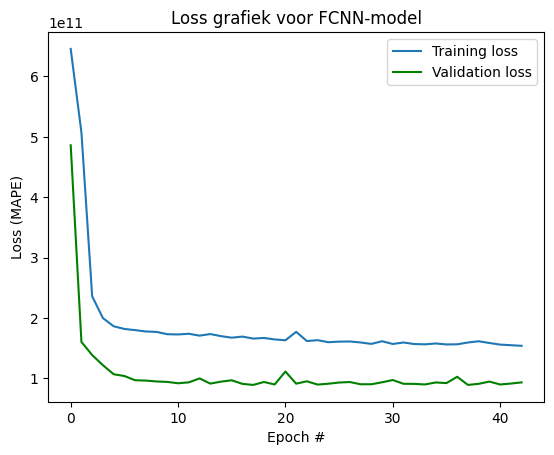

In [ ]:
plt.plot(h_fcnn.history['loss'], label='Training loss')
plt.plot(h_fcnn.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MAPE)')
plt.title('Loss grafiek voor FCNN-model')
plt.legend()
plt.show()

Zoals in de grafiek is te zien, is er sprake van geen van overfitting. Overfitting wordt namelijk aangeduid door het stijgen van de validatie loss.

Nu het model is getrained en de loss is bekeken, kan de voorspelling worden geupload naar kaggle. Aan de hand van de voorspellingen kan er een csv bestand aangemaakt worden voor de kaggle competitie. Omdat deze bestanden vaker moeten worden aangemaakt en om de bestanden overzichtelijk en uniform te houden is hiervoor een functie aangemaakt.

In [ ]:
model_save_path = '/content/drive/My Drive/Colab Notebooks/DeepLearning_2024/Opdracht 1/modelversies/fcnn_model_v1.h5'
fcnn.save(model_save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model


model_load_path = '/content/drive/My Drive/Colab Notebooks/DeepLearning_2024/Opdracht 1/modelversies/fcnn_model_v1.h5'


model = load_model(model_load_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 14241 (55.63 KB)
Trainable params: 14241 (55.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# score verbeteren

In [ ]:
!pip install optuna

In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Laad je data hier
# Voorbeeld: train_data = pd.read_csv('train.csv')
# test_data = pd.read_csv('test.csv')

# Splits je data in features en target
X = train_data.drop(['House ID', 'Price'], axis=1).values
y = train_data['Price'].values

# Scalen van de data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splits de data in train en test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

def create_model(trial):
    # Bepaal de architectuur van het model met de trial suggest methoden
    model = Sequential()
    model.add(Dense(trial.suggest_int('input_neurons', 5, 128), activation='relu', input_shape=(X_train.shape[1],)))

    # Voeg dynamisch lagen toe
    n_layers = trial.suggest_int('n_layers', 1, 4)
    for i in range(n_layers):
        model.add(Dense(trial.suggest_int(f'n_units_l{i}', 5, 128), activation='relu'))

    model.add(Dense(1, activation='linear'))
    return model

def objective(trial):
    model = create_model(trial)

    # Kies hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=lr),
                  metrics=['mean_absolute_percentage_error'])

    early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=100, batch_size=16, callbacks=[early_stop], verbose=0)

    loss, mape = model.evaluate(X_test, y_test, verbose=0)
    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

print('Beste trial:', study.best_trial.params)


[I 2024-03-06 17:52:20,178] A new study created in memory with name: no-name-9610b881-d5d6-49b1-85e3-1c082fd6f9bd
[I 2024-03-06 17:52:46,168] Trial 0 finished with value: 99.3311996459961 and parameters: {'input_neurons': 100, 'n_layers': 3, 'n_units_l0': 104, 'n_units_l1': 30, 'n_units_l2': 47, 'lr': 3.8294502480943596e-05}. Best is trial 0 with value: 99.3311996459961.
[I 2024-03-06 17:53:01,987] Trial 1 finished with value: 79.1481704711914 and parameters: {'input_neurons': 71, 'n_layers': 1, 'n_units_l0': 53, 'lr': 0.002360547323927169}. Best is trial 1 with value: 79.1481704711914.
[I 2024-03-06 17:53:16,841] Trial 2 finished with value: 64.02296447753906 and parameters: {'input_neurons': 120, 'n_layers': 3, 'n_units_l0': 39, 'n_units_l1': 53, 'n_units_l2': 63, 'lr': 0.0014710485786897946}. Best is trial 2 with value: 64.02296447753906.
[I 2024-03-06 17:53:38,342] Trial 3 finished with value: 81.17350769042969 and parameters: {'input_neurons': 83, 'n_layers': 2, 'n_units_l0': 54, 

In [ ]:
model_1 = Sequential()
model_1.add(Dense(5, activation='relu', input_shape=(X_train.shape[1],)))  # Correct aantal input features
model_1.add(Dense(117, activation='relu'))
model_1.add(Dense(35, activation='relu'))
model_1.add(Dense(91, activation='relu'))
model_1.add(Dense(76, activation='relu'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(optimizer=Adam(learning_rate=0.00664967481916384),
                loss='mean_squared_error',
                metrics=['mean_absolute_percentage_error'])

# Gebruik dezelfde early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

model_1.fit(X_train, y_train, validation_data=(X_test, y_test),
            epochs=100, batch_size=16, callbacks=[early_stop], verbose=0)

# Evalueer het model
loss, mape = model_1.evaluate(X_test, y_test, verbose=0)
print(f'Validation MAPE: {mape}')



NameError: name 'Sequential' is not defined

score op kaggle: 0,59605

**model_1_1**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Modeldefinitie
model_1_1 = Sequential()
model_1_1.add(Dense(5, activation='relu', input_shape=(X_train.shape[1],)))  # Correct aantal input features
model_1_1.add(Dropout(0.2))  # Dropout toegevoegd
model_1_1.add(Dense(117, activation='relu'))
model_1_1.add(Dropout(0.2))  # Dropout toegevoegd
model_1_1.add(Dense(35, activation='relu'))
model_1_1.add(Dropout(0.2))  # Dropout toegevoegd
model_1_1.add(Dense(91, activation='relu'))
model_1_1.add(Dropout(0.2))  # Dropout toegevoegd
model_1_1.add(Dense(76, activation='relu'))
model_1_1.add(Dropout(0.2))  # Dropout toegevoegd
model_1_1.add(Dense(1, activation='linear'))

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_schedule = LearningRateScheduler(scheduler)

# Compileer het model
model_1_1.compile(optimizer=Adam(learning_rate=0.00664967481916384),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_percentage_error'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Train het model
# Zorg ervoor dat X_train, y_train, X_test, en y_test gedefinieerd zijn voordat je dit uitvoert.
model_1_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[early_stop, lr_schedule], verbose=0)

# Evalueer het model
loss, mape = model_1_1.evaluate(X_test, y_test, verbose=0)
print(f'Validation MAPE: {mape}')


NameError: name 'X_train' is not defined

score op kaggle: 0,58263

**model_1_2**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l1_l2
import numpy as np

# Modeldefinitie
model_1_2 = Sequential([
    Dense(5, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.1),  # Lichtere dropout in de eerste laag
    Dense(120, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),  # Aangepast aantal neuronen + regularisatie
    Dropout(0.2),
    Dense(40, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),  # Aangepast aantal neuronen + regularisatie
    Dropout(0.25),
    Dense(80, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),  # Aangepast aantal neuronen + regularisatie
    Dropout(0.3),
    Dense(70, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),  # Aangepast aantal neuronen + regularisatie
    Dropout(0.35),
    Dense(1, activation='linear')
])

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.9
    else:
        return lr * np.exp(-0.1)

lr_schedule = LearningRateScheduler(scheduler)

# Compileer het model
model_1_2.compile(optimizer=Adam(learning_rate=0.00664967481916384),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_percentage_error'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train het model
model_1_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[early_stop, lr_schedule], verbose=0)

# Evalueer het model
loss, mape = model_1_2.evaluate(X_test, y_test, verbose=0)
print(f'Validation MAPE: {mape}')


score op kaggle: 0,99372

**model_1_3**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Modeldefinitie
model_1_3 = Sequential([
    Dense(5, activation='relu', input_shape=(X_train.shape[1],)),  # Correct aantal input features
    Dropout(0.25),  # Licht verhoogde dropout
    Dense(117, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.25),
    Dense(35, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.25),
    Dense(91, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.25),
    Dense(76, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.25),
    Dense(1, activation='linear')
])

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.2)  # Aangepaste verlagingssnelheid

lr_schedule = LearningRateScheduler(scheduler)

# Compileer het model
model_1_3.compile(optimizer=Adam(learning_rate=0.00664967481916384),  # Start learning rate
                  loss='mean_squared_error',
                  metrics=['mean_absolute_percentage_error'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Training van het model (zorg ervoor dat X_train, y_train, X_test, en y_test correct gedefinieerd zijn)
model_1_3.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=100, batch_size=16, callbacks=[early_stop, lr_schedule], verbose=0)

# Evalueer het model
loss, mape = model_1_3.evaluate(X_test, y_test, verbose=0)
print(f'Validation MAPE: {mape}')


score op kaggle:  0,96494

**model_1_4**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Modeldefinitie
model_1_4 = Sequential([
    Dense(5, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.15),  # Iets verlaagde dropout vergeleken met model_1_3
    Dense(117, activation='relu'),
    Dropout(0.15),
    Dense(35, activation='relu'),
    Dropout(0.15),
    Dense(91, activation='relu'),
    Dropout(0.15),
    Dense(76, activation='relu'),
    Dropout(0.15),
    Dense(1, activation='linear')
])

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * np.exp(-0.05)  # Subtielere verlagingssnelheid

lr_schedule = LearningRateScheduler(scheduler)

# Compileer het model
model_1_4.compile(optimizer=Adam(learning_rate=0.00664967481916384),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_percentage_error'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train het model
model_1_4.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=100, batch_size=16, callbacks=[early_stop, lr_schedule], verbose=0)

# Evalueer het model
loss, mape = model_1_4.evaluate(X_test, y_test, verbose=0)
print(f'Validation MAPE: {mape}')


score op kaggle: 0,98515

**model_1_5**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Definieer de beste hyperparameters volgens Optuna's output
best_params = {
    'input_neurons': 127,
    'n_layers': 4,
    'n_units_l0': 14,
    'n_units_l1': 118,
    'n_units_l2': 128,
    'n_units_l3': 45,
    'lr': 0.01328913981701352
}

# Bouw het model met de beste hyperparameters
def build_model_with_best_params(params):
    model = Sequential()
    model.add(Dense(params['input_neurons'], activation='relu', input_shape=(X_train.shape[1],)))

    # Voeg de dynamisch bepaalde lagen toe
    layer_units = [params[f'n_units_l{i}'] for i in range(params['n_layers'])]
    for units in layer_units:
        model.add(Dense(units, activation='relu'))

    model.add(Dense(1, activation='linear'))

    return model

# Maak het model aan
model = build_model_with_best_params(best_params)

# Compileer het model met de beste learning rate
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mean_squared_error',
              metrics=['mean_absolute_percentage_error'])

# Stel de EarlyStopping callback in
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Train het model
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=100, batch_size=16, callbacks=[early_stop], verbose=0)

# Evalueer het model
loss, mape = model.evaluate(X_test, y_test, verbose=0)
print(f'Validation MAPE: {mape}')


# Modelaanpassingen en Verbeteringen

In deze versie van het neurale netwerkmodel zijn verschillende aanpassingen gemaakt ten opzichte van de eerste versie van het model. Deze wijzigingen zijn bedoeld om de modelprestaties te verbeteren, zoals gemeten door een lagere Mean Absolute Percentage Error (MAPE) op Kaggle. Hier volgt een overzicht van de belangrijkste aanpassingen:

### Architectuur van het Model
- **Verhoging van het Aantal Neuronen**: In elke laag van het model is het aantal neuronen aangepast om de modelcomplexiteit te verhogen. Dit stelt het model in staat om complexere patronen in de data te leren.
    - De inputlaag en de eerste verborgen laag bevatten nu 128 neuronen.
    - De tweede verborgen laag bevat 64 neuronen.
    - De derde verborgen laag bevat 32 neuronen.
- **Dropout Toegevoegd**: In elke verborgen laag is een dropout van 0.2 toegepast. Dropout helpt overfitting te verminderen door willekeurig een deel van de neuronen tijdens de training uit te schakelen, wat zorgt voor een robuuster netwerk.

### Hyperparameters
- **Learning Rate**: De learning rate van de Adam optimizer is ingesteld op 0.001. Dit is een standaardwaarde die vaak een goed evenwicht biedt tussen snelheid en nauwkeurigheid van de training.
- **Batch Size**: De batch size is vastgesteld op 32. Dit is een veelgebruikte grootte die een goede balans biedt tussen de snelheid van de training en de nauwkeurigheid van de gradient updates.
- **Aantal Epochs**: Er is gekozen voor een maximum van 1000 epochs, met early stopping toegepast om te voorkomen dat het model te lang traint en overfit raakt.

### Training en Validatie
- **Validation Split**: Een validatiesplit van 0.2 wordt gebruikt om een deel van de trainingsdata apart te zetten voor validatiedoeleinden. Dit helpt bij het monitoren van het modelprestaties op niet-getrainde data.
- **Early Stopping**: Early stopping wordt gebruikt met een `patience` van 20 epochs. Dit betekent dat de training stopt als het validatieverlies voor 20 opeenvolgende epochs niet verbetert, waarbij de beste modelgewichten worden hersteld.

Deze aanpassingen zijn gemaakt met het doel om de nauwkeurigheid van het model te verbeteren en overfitting te verminderen. Door het aantal neuronen te verhogen en dropout toe te passen, is het model beter in staat om de onderliggende patronen in de data te leren zonder te veel te leren van de ruis of specifieke details van de trainingsset.




**versie 2 van het model (voorspelling_FCNN-versie_2)** score: 0,57711

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd  # Zorg ervoor dat je pandas hebt geïmporteerd om met DataFrame te werken

# Aannemend dat train_data je DataFrame is met de trainingsdata
# Aanmaken van de random_state SEED
SEED = 42

# Opsplitsten van data in X en y
X = train_data.drop(['House ID', 'Price'], axis=1)
y = train_data['Price']

# Toepassen van train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=SEED)

# Modeldefinitie
model_2 = Sequential()

# Input layer en eerste hidden layer met Dropout
model_2.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model_2.add(Dropout(0.2))

# Tweede hidden layer
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.2))

# Derde hidden layer
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.2))

# Output layer
model_2.add(Dense(1, activation='linear'))

# Compileer het model
model_2.compile(optimizer=Adam(learning_rate=0.001),
                loss='mean_squared_error',
                metrics=['mean_absolute_error'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train het model
history = model_2.fit(X_train, y_train,
                      batch_size=32,
                      epochs=1000,
                      validation_data=(X_val, y_val),
                      callbacks=[early_stop])


**model versie 3 (voorspelling_FCNN-versie_3)** score: 0,99946

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Modeldefinitie
model_3 = Sequential()

# Input layer en eerste hidden layer met Dropout
model_3.add(Dense(128, input_shape=(X_train.shape[1],)))
model_3.add(BatchNormalization())
model_3.add(LeakyReLU(alpha=0.01))
model_3.add(Dropout(0.1))  # Verlaagde dropout

# Tweede hidden layer
model_3.add(Dense(64))
model_3.add(BatchNormalization())
model_3.add(LeakyReLU(alpha=0.01))
model_3.add(Dropout(0.1))  # Verlaagde dropout

# Derde hidden layer
model_3.add(Dense(32))
model_3.add(BatchNormalization())
model_3.add(LeakyReLU(alpha=0.01))
model_3.add(Dropout(0.1))  # Verlaagde dropout

# Output layer
model_3.add(Dense(1, activation='linear'))

# Compileer het model
model_3.compile(optimizer=Adam(learning_rate=0.0009),  # Fijn afgestemde learning rate
              loss='mean_absolute_percentage_error',  # Verandering van loss functie
              metrics=['mean_absolute_error'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train het model
history = model_3.fit(X_train, y_train,
                    batch_size=32,
                    epochs=500,  # Verminderde het aantal epochs
                    validation_split=0.2,
                    callbacks=[early_stop])



**model versie 4 (voorspelling_FCNN-versie_4)** score: 0,57714

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Modeldefinitie
model_4 = Sequential()

# Input layer en eerste hidden layer met Dropout
model_4.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model_4.add(Dropout(0.1))  # Een lichtere dropout kan soms beter presteren

# Tweede hidden layer
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.1))  # Consistent houden van dropout

# Derde hidden layer
model_4.add(Dense(32, activation='relu'))
model_4.add(Dropout(0.1))  # Consistent houden van dropout

# Output layer
model_4.add(Dense(1, activation='linear'))

# Compileer het model
model_4.compile(optimizer=Adam(learning_rate=0.001),  # Terug naar de originele learning rate
              loss='mean_squared_error',  # Gebruik MSE zoals in het tweede model
              metrics=['mean_absolute_percentage_error'])  # Voor directe feedback over de MAPE score

# Early stopping callback om te voorkomen dat we overfitting krijgen
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train het model
history = model_4.fit(X_train, y_train,
                    batch_size=32,
                    epochs=500,  # Een gemiddeld aantal epochs
                    validation_split=0.2,
                    callbacks=[early_stop])


**versie 5 van het model(voorspelling_FCNN-versie_5)** score: 0,99971

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Modeldefinitie
model_5 = Sequential()

# Input layer
model_5.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model_5.add(BatchNormalization())  # Verbeterde normalisatie

# Eerste hidden layer met Dropout
model_5.add(Dense(256, activation='relu'))
model_5.add(Dropout(0.3))  # Iets verhoogde dropout voor deze laag

# Tweede hidden layer
model_5.add(Dense(128, activation='relu'))
model_5.add(BatchNormalization())

# Derde hidden layer met Dropout
model_5.add(Dense(64, activation='relu'))
model_5.add(Dropout(0.2))

# Vierde hidden layer
model_5.add(Dense(64, activation='relu'))
model_5.add(BatchNormalization())

# Output layer
model_5.add(Dense(1, activation='linear'))

# Compileer het model
model_5.compile(optimizer=Adam(learning_rate=0.0005),  # Aangepaste learning rate
                loss='mean_absolute_percentage_error',  # Gebruik MAPE als loss functie
                metrics=['mean_absolute_error'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train het model
history = model_5.fit(X_train, y_train,
                      batch_size=64,  # Aangepaste batch size
                      epochs=400,  # Aangepaste aantal epochs
                      validation_split=0.2,
                      callbacks=[early_stop])


**versie 6 van het model(voorspelling_FCNN-versie_6)** score: 0,99

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Modeldefinitie
model_6 = Sequential()

# Input layer
model_6.add(Dense(256, input_shape=(X_train.shape[1],)))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(Dropout(0.3))

# Toevoegen van meer hidden layers met verhoogde dropout
model_6.add(Dense(128))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(Dropout(0.3))

model_6.add(Dense(64))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(Dropout(0.3))

# Output layer
model_6.add(Dense(1, activation='linear'))

# Compileer het model
model_6.compile(optimizer=Adam(learning_rate=0.0005),
                loss='mean_squared_error',
                metrics=['mean_absolute_percentage_error'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train het model
history = model_6.fit(X_train, y_train,
                      batch_size=32,
                      epochs=800,  # Aangepast aantal epochs
                      validation_split=0.2,
                      callbacks=[early_stop])


Met die code heb ik het eerste model opgeslagen in een nieuwe map genaamd modelversies

In [ ]:
def kaggle_csv(model, suffix):
    """
    Deze functie maakt de voorspelling op de test dataset
    en vormt deze om tot een csv bestand om in te kunnen
    leveren op Kaggle.

    Parameters:
    ----------
    model : ML-model of DL-model
        De naam die is gegeven aan het ML-model of DL-model
        dat wordt gebruikt om te voorspellen

    suffix : str
        De 'tag' voor de naam van het csv
        bestand, zodat deze makkelijk te identificeren
        is na de submission.

    Returns:
    ----------
    None
        In plaats van een return maakt het een bestand
        aan in de map Kaggle Submissions. De namen zien
        er als volgt uit:

    """
    # Aanmaken van de voorspelling
    y_pred = model.predict(sc_test_fe)

    # Aanmaken df met alleen House ID en Price
    test_predictions_df = pd.DataFrame(
        {'House ID': test_data['House ID'],
        'Price': np.ravel(y_pred)})

    # Aanmaken van tijd
    tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

    # Aanmaken csv bestand met timestamp
    test_predictions_df.to_csv(
        f'Kaggle/voorspelling_{suffix}_{tijd}.csv',
        index=False)

    # Print voor conformatie
    print(f'voorspelling_{suffix}_{tijd}.csv has been saved!')

Nu zal de functie worden uitgevoerd om de voorspellingen te verkrijgen.

In [ ]:
# Uitvoeren van kaggle_csv functie
kaggle_csv(model_1_4, 'FCNN-versie_1_4')



- [ ] Bouw en train een dense (fully-connected) netwerk om de huizenprijzen te voorspellen op basis van de tabular data.


- [ ] Beschrijf welke lossfunctie het meest geschikt is voor dit probleem. Kies een geschikte optimizer en beschrijf kort hoe deze optimizer werkt.


- [ ] Plot je modelarchitectuur met behulp van een geschikte visualisatietool.
- [ ] Onderbouw je keuzes van het aantal convolutionele lagen, poollagen, convolutionele kernels per laag, het aantal fully-connected lagen en het aantal neuronen per laag.

## CNN from Scratch


- [ ] Plot je modelarchitectuur met behulp van een geschikte visualisatietool.
- [ ] Onderbouw je keuzes van het aantal lagen, het aantal neuronen per laag, de activeringsfuncties, de keuze van optimizer en het aantal trainingsepochs.


- [ ] Gebruik een of meer van de volgende technieken in je model. Beschrijf en motiveer je keuze:
    - [ ] L1 regularisatie
    - [ ] L2 regularisatie
    - [ ] Dropout
    - [ ] Batchnorm

- [ ] Beschrijf welke vormen van data augmentation (indien van toepassing) geschikt zijn voor dit probleem. Implementeer dit in je datapijplijn.
- [ ] Compile je model met je gekozen lossfunctie en optimizer, en train deze op de afbeeldingen.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Modeldefinitie
model_2 = Sequential()

# Input layer en eerste hidden layer met Dropout
model_2.add(Dense(128, input_shape=(5,), activation='relu'))
model_2.add(Dropout(0.2))

# Tweede hidden layer
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.2))

# Derde hidden layer
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.2))

# Output layer
model_2.add(Dense(1, activation='linear'))

# Compileer het model
model_2.compile(optimizer=Adam(learning_rate=0.001),
                loss='mean_squared_error',
                metrics=['mean_absolute_error'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train het model
history = model_2.fit(X_train, y_train,
                      batch_size=32,
                      epochs=1000,
                      validation_split=0.2,
                      callbacks=[early_stop])


**FCNN-versie_2_1** score: 0,99972

# Transfer Learning

# Multimodaal model